# Notes
- If meet id inclues a `/`, it is probably wrong.  Still don't know why, but we won't use Meet_ID anyways.
- Kyle has TWO athlete id's, 7109122 and 6459186.  Could be a problem.

# Prepare Data

In [209]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 500)

In [210]:
mdf = pd.read_csv('M_athlete_results.csv')
fdf = pd.read_csv('F_athlete_results.csv')

In [211]:
# String marks to float times in seconds
mdf['Time'] = [utils.Time(m) if (e in utils.event_classification()['Track'] and utils.ismark(m)) else None for e, m in zip(mdf['Event'], mdf['Mark'])]
fdf['Time'] = [utils.Time(m) if (e in utils.event_classification()['Track'] and utils.ismark(m)) else None for e, m in zip(fdf['Event'], fdf['Mark'])]

In [212]:
# String events to float distance in meters
mdf['Distance'] = [utils.string_to_distance(e) if e in utils.event_classification()['Track'] else None for e in mdf['Event']]
fdf['Distance'] = [utils.string_to_distance(e) if e in utils.event_classification()['Track'] else None for e in fdf['Event']]

In [213]:
elevations = {
    'Western Colorado': 7700,
    'University of Colorado': 5300,
    'Colorado Mesa': 4500,
    'UCCS': 6000,
    'Colorado College': 6000,
    'Colorado State': 5000,
    'Colorado Invitational': 5300,
    'NAU': 6900,
    'BYU': 4600,
    'SD Mines': 3200,
    'New Mexico': 5300,
    'Wyoming': 6000,
    'Adams State': 7500,
    'TWO': {
        'Mines': ['SD ', 'South Dakota', 5600]
    }
}

mdf['Elevation3k'] = [0]*len(mdf)
for m, e in elevations.items():
    if m == 'TWO':
        for m2, e2 in e.items():
            mdf['Elevation3k'][(mdf['Meet_Name'].str.contains(m2)) & ~((mdf['Meet_Name'].str.contains(e2[0]))) & ~((mdf['Meet_Name'].str.contains(e2[1])))] = e2[2]-3000
    else:
        mdf['Elevation3k'][mdf['Meet_Name'].str.contains(m)] = e-3000
        
fdf['Elevation3k'] = [0]*len(fdf)
for m, e in elevations.items():
    if m == 'TWO':
        for m2, e2 in e.items():
            fdf['Elevation3k'][(fdf['Meet_Name'].str.contains(m2)) & ~((fdf['Meet_Name'].str.contains(e2[0]))) & ~((fdf['Meet_Name'].str.contains(e2[1])))] = e2[2]-3000
    else:
        mdf['Elevation3k'][fdf['Meet_Name'].str.contains(m)] = e-3000

In [214]:
mdf = utils.get_stat_col(mdf, 'Time')

In [7]:
xcnats_m = mdf.loc[mdf['Meet_Name'] == 'NCAA Division II Cross Country Championships'].sort_values(['Place', 'Mark'])
xcnats_f = fdf.loc[fdf['Meet_Name'] == 'NCAA Division II Cross Country Championships'].sort_values(['Place', 'Mark'])

In [8]:
def prior_to_xc(gender, allresults=False, nats=True):
    if gender == 'M':
        DF = mdf
        xcnats = xcnats_m
    elif gender == 'F':
        DF = fdf
        xcnats = xcnats_f
    # PRs before a specified year
    xcnats_dic = {}
    for year in range(2012, 2020):
        print(year, end='...')
        df1 = DF.loc[((DF['Year'] <= year) & (DF['Season'] != 'Cross Country') & (DF['Distance'] > 0)) | ((DF['Year'] < year) & (DF['Season'] == 'Cross Country'))]
        for s in ['Outdoor', 'Indoor']:
            records = utils.get_records()[s]
            for e, m in records.items():
                df1 = df1.loc[(df1['Season'] != s) | (df1['Event'] != e) | ((df1['Season'] == s) & (df1['Event'] == e) & (df1['Time'] >= utils.Time(m)))]
        df2 = xcnats.loc[xcnats['Year'] == year]
        if allresults:
            df3 = df1    # all results rather than just PRs
        else:
            df3 = df1.sort_values('Time').drop_duplicates(subset=['Athlete ID', 'Distance', 'Season'])    # Season specific PRs?
        if nats:
            df = df3.join(df2.set_index('Athlete ID'), on='Athlete ID', rsuffix='NATS')
        else:
            df = df3
            df = df[
                [
                    'Name',
                    'Athlete ID',
                    'Academic_Year',
                    'School', 
                    'Conference',
                    'Meet_Name',
                    'Year',
                    'Season',
                    'Place',
                    'Time',
                    'Distance',
                    'YearNATS',
                    'DistanceNATS',
                    'PlaceNATS',
                    'TimeNATS'
                ]
            ]
            df = df.dropna(subset=['DistanceNATS'])
        xcnats_dic[year] = df
    print('Done')
    return xcnats_dic

In [9]:
resvar = False
natsvar = True
xcnats_dic_m = prior_to_xc('M', resvar, natsvar)

2012...2013...2014...2015...2016...2017...2018...2019...Done


In [10]:
if resvar:
    assert len(mdf.loc[(mdf['Name']=='KALE ADAMS') & (mdf['Season']=='Cross Country') & (mdf['Year'] < 2019)]) == len(xcnats_dic_m[2019].loc[(xcnats_dic_m[2019]['Name']=='KALE ADAMS') & (xcnats_dic_m[2019]['Season']=='Cross Country')])

In [218]:
for year, df in xcnats_dic_m.items():
    champs = mdf.loc[(mdf['Prelim/Final']!='P') & (mdf['Meet_Name'].str.contains('Championship')) & (mdf['Place'] <= 3) & (((mdf['Year'] < year) & (mdf['Season'] == 'Cross Country')) | ((mdf['Year'] <= year) & (mdf['Season'] != 'Cross Country')))].groupby('Athlete ID').count()
    champs['Championship Medals'] = champs['Name']
    champs = champs['Championship Medals']
    df = df.join(champs, on='Athlete ID')
    df['Championship Medals'].fillna(0, inplace=True)
    xcnats_dic_m[year] = df

In [12]:
for year, df in xcnats_dic_m.items():
    champs = mdf.loc[(mdf['Prelim/Final']!='P') & ((mdf['Meet_Name'].str.contains('NCAA Division II')) & ~(mdf['Meet_Name'].str.contains('Region'))) & (((mdf['Year'] < year) & (mdf['Season'] == 'Cross Country') & (mdf['Place'] <= 40)) | ((mdf['Year'] <= year) & (mdf['Season'] != 'Cross Country') & (mdf['Place'] <= 8)))].groupby('Athlete ID').count()
    champs['All Americans'] = champs['Name']
    champs = champs['All Americans']
    df = df.join(champs, on='Athlete ID')
    df['All Americans'].fillna(0, inplace=True)
    xcnats_dic_m[year] = df

In [220]:
df.loc[((mdf['Meet_Name'].str.contains('NCAA')) & ~(mdf['Meet_Name'].str.contains('Region'))) & (((df['Year'] < year) & (df['Season'] == 'Cross Country') & (df['Place'] <= 40)) | ((df['Year'] <= year) & (df['Season'] != 'Cross Country') & (df['Place'] <= 8)))]

,Name,Athlete ID,Grade,Academic_Year,School,Conference,Meet_ID,Meet_Name,Meet_Start,Meet_End,...,EventNATS,MarkNATS,PlaceNATS,Prelim/FinalNATS,TimeNATS,DistanceNATS,TimeAVGNATS,TimeSTDNATS,Championship Wins,All Americans
38592,JUSTIN SNYDER,5108968,Unknown,NaN,CONCORD,NaN,53483,SPIRE NCAA D-II Indoor T&F Team Challenge,"Feb 6, 2015","Feb 7, 2015",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
33901,SERGIO MIRANDA,5652744,REDSHIRT,UNATTACHED,LEWIS,NaN,47011,NCAA Division II Indoor Track & Field Champion...,"Mar 11, 2016","Mar 12, 2016",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
50991,DREW WINDLE,3672017,Unknown,NaN,ASHLAND,NaN,4489/,NCAA Division II Team Challenge,"Feb 4, 2012","Feb 4, 2012",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
39062,DANTE CARTER,5970828,Unknown,NaN,CSU-PUEBLO,NaN,11176,MINES NCAA DII Invite,"Jan 27, 2017","Jan 28, 2017",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
65706,BRIAN BAUM,3672011,Unknown,NaN,ASHLAND,NaN,23167,NCAA Division II Team Challenge,"Feb 4, 2012","Feb 4, 2012",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
10247,EVAN SUTHERLAND,6447888,SR,4,WESTERN COLORADO,Rocky Mountain AC,17333,ASU NCAA Qualifier,"Feb 9, 2018","Feb 10, 2018",...,10K,31:22.4,82.0,NaN,1882.4,10000.0,1894.050000,16.475588,0.0,1.0
28288,MARC MARCANO,5651992,Unknown,NaN,WESTERN COLORADO,NaN,43645,ASU NCAA Qualifier,"Feb 9, 2018","Feb 10, 2018",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
7876,AUSTIN SPEER,5504393,REDSHIRT,UNATTACHED,ADAMS STATE,Rocky Mountain AC,62714,Adams State University NCAA Qualifier,"Feb 8, 2019","Feb 9, 2019",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
40216,BRADY SPEICHER,4511803,Unknown,NaN,MSU-MOORHEAD,NaN,10762,NCAA Division II Indoor Track & Field Champion...,"Mar 11, 2016","Mar 12, 2016",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0
30919,CHANDLER REID,4543324,Unknown,NaN,ADAMS STATE,NaN,11246,NCAA Division II Indoor Track & Field Champion...,"Mar 11, 2016","Mar 12, 2016",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0


In [13]:
DF = pd.DataFrame()
for y, d in xcnats_dic_m.items():
    DF = pd.concat([DF, d])
DF['Time_since_PR'] = DF['YearNATS']-DF['Year']
DF, seasondic = utils.make_dummy_col(DF, 'Season')
DF = DF.loc[DF['Distance'] > 0]

In [14]:
inv_map = {v: k for k, v in seasondic.items()}
year = 2020
xc = inv_map['Cross Country']

In [15]:
mdf, _ = utils.make_dummy_col(mdf, 'Season', dic=seasondic)

In [16]:
'''mdf['Distance'] /= 1000.
DF['Distance'] /= 1000.'''

"mdf['Distance'] /= 1000.\nDF['Distance'] /= 1000."

In [17]:
print('mdf', mdf.shape)
for k, v in xcnats_dic_m.items():
    print(k, v.shape)
print('DF', DF.shape)
seasondic

mdf (66736, 21)
2012 (1401, 43)
2013 (3075, 43)
2014 (4514, 43)
2015 (6209, 43)
2016 (7832, 43)
2017 (9422, 43)
2018 (11318, 43)
2019 (13410, 43)
DF (57181, 44)


{0: 'Outdoor', 1: 'Indoor', 2: 'Cross Country', 3: 'Out of Season'}

# Modeling

In [18]:
del xcnats_m
del xcnats_f

In [19]:
# import tensorflow as tf
# import tensorflow.keras as keras
import numpy as np
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA

## Feature Learning: PCA (Principal Component Analysis) 

In [20]:
def get_knn_training_scores(ks, model_features, model_labels):
    """Determine the f1-score of k values for kNN on a given data set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the training set
    """
    # YOUR CODE HERE
    dictionary = {}
    for k in ks:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(model_features, model_labels)
      validationPredictions = knn.predict(model_features)
      f1 = f1_score(model_labels, validationPredictions, average="weighted")
      dictionary[k] = f1
    return dictionary

def get_knn_validation_scores(ks, model_features, model_labels, validation_features, validation_labels):
    """Train a model on a dataset then return the F-1 score on another set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        validation_features (iterable): the features from the validation set to test on
        validation_labels (iterable): the labels from the validation set to test on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the validation set
    """
    # YOUR CODE HERE
    dictionary = {}
    for k in ks:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(model_features, model_labels)
      validationPredictions = knn.predict(validation_features)
      f1 = f1_score(validation_labels, validationPredictions, average="weighted")
      dictionary[k] = f1
    return dictionary

In [21]:
allamerican = True
target = 'PlaceNATS'
#target = 'All Americans'
aa = True
if aa:
    features = ['Distance', 'Season', 'Time', 'Time_since_PR', 'Championship Medals', 'All Americans', 'TimeAVG', 'TimeSTD']
else:
    features = ['Distance', 'Season', 'Time', 'Time_since_PR', 'Championship Medals', 'TimeAVG', 'TimeSTD']

In [22]:
features.append('Elevation3k')

In [23]:
X_train, X_test, y_train, y_test = utils.get_train_test(DF, target, features)

In [24]:
if target == 'PlaceNATS':
    if allamerican:
        y_train[y_train<=40] = 1
        y_train[y_train>40] = 0
        y_test[y_test<=40] = 1
        y_test[y_test>40] = 0
    else:
        categories = 2
        width = 100
        for i in range(1, categories+1):
            y_train[(y_train<=i*width) & (y_train>(i-1)*width)] = float(i)
        y_train[y_train>categories*width] = float(categories+1)
        for i in range(1, categories+1):
            y_test[(y_test<=i*width) & (y_test>(i-1)*width)] = float(i)
        y_test[y_test>categories*width] = float(categories+1)
    y_test

In [ ]:
pca_tf = PCA(n_components=2)
X_train_pca = pca_tf.fit_transform(X_train)
X_test_pca = pca_tf.transform(X_test)

In [395]:
c0 = plt.scatter(X_train_pca[:,0].reshape(-1,1)[y_train == 0], X_train_pca[:,1].reshape(-1,1)[y_train == 0], color="r")
c1 = plt.scatter(X_train_pca[:,0].reshape(-1,1)[y_train == 1], X_train_pca[:,1].reshape(-1,1)[y_train == 1], color="g")
plt.legend((c0, c1), ("Class 0", "Class 1"))
plt.show()

In [27]:
X_model, X_valid, y_model, y_valid = train_test_split(X_train_pca, y_train, random_state=0, test_size=0.2)

In [26]:
X_model, X_valid, y_model, y_valid = train_test_split(X_train, y_train, random_state=0, test_size=0.2)

In [28]:
ksToTest = [1,3,5,7,10,20,50,100]
training_scores = get_knn_training_scores(ksToTest, X_model, y_model)
validation_scores = get_knn_validation_scores(ksToTest, X_model, y_model, X_valid, y_valid)

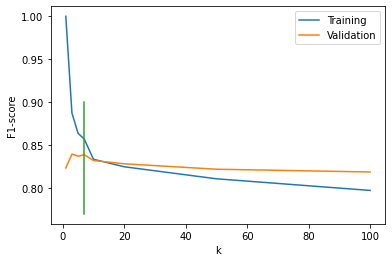

In [29]:
pd.Series(training_scores, name="Training").plot(kind="line")
pd.Series(validation_scores, name="Validation").plot(kind="line", label="Validation")
plt.legend()
bestk = 7
plt.plot([bestk, bestk], [0.77, 0.9])
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

In [30]:
ksToTest = list(range(1, 26, 2))
training_scores = get_knn_training_scores(ksToTest, X_model, y_model)
validation_scores = get_knn_validation_scores(ksToTest, X_model, y_model, X_valid, y_valid)

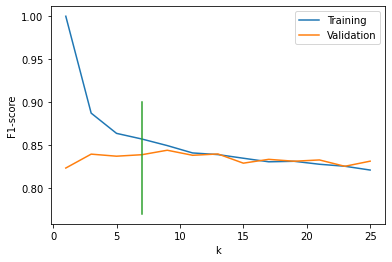

In [31]:
pd.Series(training_scores, name="Training").plot(kind="line")
pd.Series(validation_scores, name="Validation").plot(kind="line", label="Validation")
plt.legend()
plt.xlabel("k")
plt.ylabel("F1-score")
bestk = 7
plt.plot([bestk, bestk], [0.77, 0.9])
plt.show()

In [32]:
bestk

7

In [35]:
clf = KNeighborsClassifier(bestk)
clf.fit(X_train, y_train)
testPredictions = clf.predict(X_test)
# 0.8289068836677437, no pca

In [34]:
clf = KNeighborsClassifier(bestk)
clf.fit(X_train_pca, y_train)
testPredictions = clf.predict(X_test)
# 0.8238705881664217, pca

NameError: name 'X_train_pca' is not defined

In [36]:
clf_pca = KNeighborsClassifier(bestk)
clf_pca.fit(X_train_pca, y_train)
testPredictions_pca = clf_pca.predict(X_test_pca)

Confusion Matrix: 

[[2011   99]
 [ 292  142]]


Classification Report:

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      2110
         1.0       0.59      0.33      0.42       434

    accuracy                           0.85      2544
   macro avg       0.73      0.64      0.67      2544
weighted avg       0.82      0.85      0.83      2544



F1-Score:

0.827693223582


In [403]:
clf_kernel = KNeighborsClassifier(bestk)
clf_kernel.fit(X_inverse, y_train)
testPredictions_kernel = clf_kernel.predict(X_inverse_test)

In [404]:
clf_mi = KNeighborsClassifier(bestk)
clf_mi.fit(mi_X_train, y_train)
testPredictions_mi = clf_mi.predict(mi_X_test)

In [405]:
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, testPredictions_mi))
print("\n\nClassification Report:\n")
print(classification_report(y_test, testPredictions_mi))
print('\n\nF1-Score:\n')
print(f1_score(y_test, testPredictions_mi, average="weighted"))

Confusion Matrix: 

[[2007  103]
 [ 283  151]]


Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      2110
         1.0       0.59      0.35      0.44       434

   micro avg       0.85      0.85      0.85      2544
   macro avg       0.74      0.65      0.68      2544
weighted avg       0.83      0.85      0.83      2544



F1-Score:

0.8315256558565027


In [406]:
tests2020 = [
    ('LUKE JULIAN', 5., 3.),
    ('DYLAN KO', 2., 1.),
    ('KYLE MORAN', 1., 1.),
    ('LUC HAGEN', 1., 2.),
    ('JAKE MITCHEM', 3., 1.),
    ('MAX SEVCIK', .0, .0),
    ('CHRIS CATHCART', .0, .0),
    ('BO RAADAM', .0, .0),
    ('TAYLOR STACK', 9., 6.),
    ('CHARLIE SWEENEY', 3., 5.),
    ('CARSON BIX', 1., 1.),
    ('ISAIAH RODARTE', 1., .0),
    ('NATHAN DAVIS', .0, .0),
    ('PADDY ROBB', 2., .0),
    ('JOHN O\'MALLEY', .0, .0),
    ('EVAN SUTHERLAND', 1., .0)
]

In [407]:
year = 2020
for i in tests2020:
    name = i[0]
    c = i[1]
    if name != 'KYLE MORAN':
        subject = mdf.loc[(mdf['Name']==name) & (mdf['Distance'] > 0) & (((mdf['Year'] <= year) & (mdf['Season'].values != xc) & (mdf['Distance'] > 0)) | ((mdf['Year'] < year) & (mdf['Season'].values == xc)))]
    else:
        subject = mdf.loc[(mdf['Athlete ID']==7109122) & (mdf['Name']==name) & (mdf['Distance'] > 0) & (((mdf['Year'] <= year) & (mdf['Season'].values != xc) & (mdf['Distance'] > 0)) | ((mdf['Year'] < year) & (mdf['Season'].values == xc)))]
    subject['Time_since_PR'] = 2020-subject['Year']
    subject['Championship Wins'] = [c] * len(subject)
    data = subject.sort_values('Time').drop_duplicates('Event')
    data = data[features].fillna(.0)

    if len(data) == 0:
        continue
    pred = clf_mi.predict(data.to_numpy())

    data['Prediction'] = [p for p in pred]
    data['All-American?'] = ['Yes' if p==1. else 'No' for p in pred]

    counts = subject['Distance'].astype(str) + ' ' + subject['Season'].astype(str)    # distinguish seasons
    counts = (counts.value_counts() / len(subject)).to_dict()

    data = data[['Distance', 'Season', 'Prediction']].to_numpy()
    
    weights = []
    for row in data:
        # print(row, '"'+str(row[0])+' '+str(int(row[1]))+'"', counts[str(row[0])+' '+str(int(row[1]))])
        weights.append(row[2]*counts[str(row[0])+' '+str(int(row[1]))])    # *(row[0]/5000)**0.5
    print(name, sum(weights))

LUKE JULIAN 0.6521739130434783
DYLAN KO 0.6956521739130435
KYLE MORAN 0.625
LUC HAGEN 0.4857142857142857
JAKE MITCHEM 0.25
MAX SEVCIK 0.3529411764705882
CHRIS CATHCART 0.125
BO RAADAM 0.5
TAYLOR STACK 0.6101694915254237
CHARLIE SWEENEY 0.6571428571428571
CARSON BIX 0.8571428571428571
ISAIAH RODARTE 0.7096774193548387
NATHAN DAVIS 0.0
PADDY ROBB 0.0
JOHN O'MALLEY 0.5
EVAN SUTHERLAND 0.030303030303030304


In [408]:
year = 2020
for i in tests2020:
    name = i[0]
    if name != "LUKE JULIAN":
        None
    c = i[1]
    a = i[2]
    if name != 'KYLE MORAN':
        subject = mdf.loc[(mdf['Name']==name) & (mdf['Distance'] > 0) & (((mdf['Year'] <= year) & (mdf['Season'].values != xc) & (mdf['Distance'] > 0)) | ((mdf['Year'] < year) & (mdf['Season'].values == xc)))]
    else:
        subject = mdf.loc[(mdf['Athlete ID']==7109122) & (mdf['Name']==name) & (mdf['Distance'] > 0) & (((mdf['Year'] <= year) & (mdf['Season'].values != xc) & (mdf['Distance'] > 0)) | ((mdf['Year'] < year) & (mdf['Season'].values == xc)))]
    subject['Time_since_PR'] = 2020-subject['Year']
    subject['Championship Medals'] = [c] * len(subject)
    if aa:
        subject['All Americans'] = [a] * len(subject)
    data = subject.sort_values('Time').drop_duplicates('Event')
    data = data[features].fillna(.0)

    if len(data) == 0:
        print(name, 'None')
        continue
    pred = clf_mi.predict(data.to_numpy())

    data['Prediction'] = [p for p in pred]
    data['All-American?'] = ['Yes' if p==1. else 'No' for p in pred]

    counts = subject['Distance'].astype(str) + ' ' + subject['Season'].astype(str)    # distinguish seasons
    counts = (counts.value_counts() / len(subject)).to_dict()

    data = data[['Distance', 'Season', 'Prediction']].to_numpy()
    
    weights = []
    for row in data:
        # print(row, '"'+str(row[0])+' '+str(int(row[1]))+'"', counts[str(row[0])+' '+str(int(row[1]))])
        if target == 'PlaceNATS':
            weights.append(row[2]*counts[str(row[0])+' '+str(int(row[1]))])    # *(row[0]/5000)**0.5
        elif target == 'All Americans':
            weights.append(row[2])    # *(row[0]/5000)**0.5
    print('-', name+':', sum(weights))

LUKE JULIAN 0.6521739130434783
DYLAN KO 0.6956521739130435
KYLE MORAN 0.625
LUC HAGEN 0.4857142857142857
JAKE MITCHEM 0.25
MAX SEVCIK 0.3529411764705882
CHRIS CATHCART 0.125
BO RAADAM 0.5
TAYLOR STACK 0.6101694915254237
CHARLIE SWEENEY 0.6571428571428571
CARSON BIX 0.8571428571428571
ISAIAH RODARTE 0.7096774193548387
NATHAN DAVIS 0.0
PADDY ROBB 0.0
JOHN O'MALLEY 0.5
EVAN SUTHERLAND 0.030303030303030304


# All American or not
## Without All-Americans
- LUKE JULIAN: 0.4782608695652174
- DYLAN KO: 0.6956521739130435
- KYLE MORAN: 0.625
- LUC HAGEN: 0.2
- JAKE MITCHEM: 0.25
- MAX SEVCIK: 0.3529411764705882
- CHRIS CATHCART: 0.125
- BO RAADAM: 0.5
- TAYLOR STACK: 0.6949152542372881
- CHARLIE SWEENEY: 0.6571428571428571
- CARSON BIX: 0.8571428571428571
- ISAIAH RODARTE: 0.7096774193548387
- NATHAN DAVIS: 0.0
- PADDY ROBB: 0.0
- JOHN O'MALLEY: 0.5
- EVAN SUTHERLAND: 0.030303030303030304
##### Distance/1000
##### k = 7; F1-Score: 0.8193457223355065

This may be skewed toward the longer distances and event specialists.  Kyle and Dylan probably would be higher if covid hadn't ended track before they could improve their resumes further.  I don't know how Stack is so low, it might be because he's run a lot of 3ks but all at altitude.  Looks like you need to run well in your most common event.  If Stack ran 5000s as much as he runs 3000s (inflated by steeple), he'd score high.

## With AA
- LUKE JULIAN: 0.4782608695652174
- DYLAN KO: 0.6956521739130435
- KYLE MORAN: 0.625
- LUC HAGEN: 0.2
- JAKE MITCHEM: 0.25
- MAX SEVCIK: 0.3529411764705882
- CHRIS CATHCART: 0.125
- BO RAADAM: 0.5
- TAYLOR STACK: 0.6949152542372881
- CHARLIE SWEENEY: 0.7142857142857143
- CARSON BIX: 0.8571428571428571
- ISAIAH RODARTE: 0.7096774193548387
- NATHAN DAVIS: 0.0
- PADDY ROBB: 0.0
- JOHN O'MALLEY: 0.5
- EVAN SUTHERLAND: 0.030303030303030304
#### Distance/1000
###### k = 7; F1-Score: 0.8244878140101404
- LUKE JULIAN: 0.4782608695652174
- DYLAN KO: 0.6956521739130435
- KYLE MORAN: 0.625
- LUC HAGEN: 0.2
- JAKE MITCHEM: 0.25
- MAX SEVCIK: 0.3529411764705882
- CHRIS CATHCART: 0.125
- BO RAADAM: 0.5
- TAYLOR STACK: 0.6949152542372881
- CHARLIE SWEENEY: 0.7142857142857143
- CARSON BIX: 0.8571428571428571
- ISAIAH RODARTE: 0.7741935483870968
- NATHAN DAVIS: 0.0
- PADDY ROBB: 0.0
- JOHN O'MALLEY: 0.5
- EVAN SUTHERLAND: 0.0

# Predict Number of All-Americans
##### k = 7; F1-Score: 0.737786316616984
- LUKE JULIAN: 5.0
- DYLAN KO: 4.0
- KYLE MORAN: 4.0
- LUC HAGEN: 2.0
- JAKE MITCHEM: 7.0
- MAX SEVCIK: 0.0
- CHRIS CATHCART: 0.0
- BO RAADAM: 1.0
- TAYLOR STACK: 15.0
- CHARLIE SWEENEY: 7.0
- CARSON BIX: 6.0
- ISAIAH RODARTE: 1.0
- NATHAN DAVIS: 0.0
- PADDY ROBB: 0.0
- JOHN O'MALLEY: 0.0
- EVAN SUTHERLAND: 0.0
##### k = 20
- LUKE JULIAN: 1.0
- DYLAN KO: 0.0
- KYLE MORAN: 1.0
- LUC HAGEN: 2.0
- JAKE MITCHEM: 1.0
- MAX SEVCIK: 0.0
- CHRIS CATHCART: 0.0
- BO RAADAM: 0.0
- TAYLOR STACK: 6.0
- CHARLIE SWEENEY: 2.0
- CARSON BIX: 4.0
- ISAIAH RODARTE: 0.0
- NATHAN DAVIS: 0.0
- PADDY ROBB: 0.0
- JOHN O'MALLEY: 0.0
- EVAN SUTHERLAND: 0.0

### Base: aa at 4, champs at 5
[1500.    0.    0.] "1500.0 0" 0.17391304347826086<br>
[1.60934e+03 1.00000e+00 0.00000e+00] "1609.34 1" 0.21739130434782608<br>
[3.e+03 1.e+00 1.e+00] "3000.0 1" 0.21739130434782608<br>
[5.e+03 0.e+00 1.e+00] "5000.0 0" 0.08695652173913043<br>
[8.e+03 2.e+00 1.e+00] "8000.0 2" 0.17391304347826086<br>
[1.e+04 2.e+00 0.e+00] "10000.0 2" 0.043478260869565216<br>
- LUKE JULIAN: 0.4782608695652174

## W/O A-A
#### Champs set to 9
[1.5e+03 0.0e+00 1.0e+00] "1500.0 0" 0.17391304347826086<br>
[1.60934e+03 1.00000e+00 0.00000e+00] "1609.34 1" 0.21739130434782608<br>
[3.e+03 1.e+00 1.e+00] "3000.0 1" 0.21739130434782608<br>
[5.e+03 0.e+00 1.e+00] "5000.0 0" 0.08695652173913043<br>
[8.e+03 2.e+00 1.e+00] "8000.0 2" 0.17391304347826086<br>
[1.e+04 2.e+00 0.e+00] "10000.0 2" 0.043478260869565216<br>
- LUKE JULIAN: 0.6521739130434783

## W/ A-A
#### All-americans set to 6, champs 5
[1.5e+03 0.0e+00 1.0e+00] "1500.0 0" 0.17391304347826086<br>
[1.60934e+03 1.00000e+00 0.00000e+00] "1609.34 1" 0.21739130434782608<br>
[3.e+03 1.e+00 1.e+00] "3000.0 1" 0.21739130434782608<br>
[5.e+03 0.e+00 1.e+00] "5000.0 0" 0.08695652173913043<br>
[8.e+03 2.e+00 1.e+00] "8000.0 2" 0.17391304347826086<br>
[1.e+04 2.e+00 0.e+00] "10000.0 2" 0.043478260869565216<br>
- LUKE JULIAN: 0.6521739130434783